## Estudio Espectro de rayos X

### Requirements

In [9]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.heasarc import Heasarc

from astroquery.esa.xmm_newton import XMMNewton 
from astropy.coordinates import SkyCoord
import astropy.units as u

from scipy.optimize import minimize

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.astrobjects import AstroObjectProject
from hyper_velocity_stars_detection.jobs.utils import load_project, read_catalog_file
from hyper_velocity_stars_detection.tools.cluster_representations import load_isochrone_from_parsec, cmd_plot, get_best_isochrone_fitted, cmd_with_cluster, cluster_representation_with_hvs
from hyper_velocity_stars_detection.tools.cluster_detection import optimize_clustering, get_main_cluster

PATH = "../data/"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
CLUSTER_NAME = "ngc 104"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, path=PATH)

df_iso = None
distance_module = None
redding = None
print(str(project))

Las muestras analizadas de ngc 104 son:
Muestras seleccionadas del objeto astronómico ngc 104 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 154362.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 16353.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16353.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 24125.

Muestras seleccionadas del objeto astronómico ngc 104 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 5444.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 1898.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 1898.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 2370.

Se han encontrado 1 fuentes de rayos X.
Estimated number of clusters: 3
Estimated number of noise points: 2269
	 - Volumen total del cluster 0: 1175.
	 - Volumen

In [4]:
XMMNewton.get_tables(only_names=True) 

INFO:astroquery:Retrieving tables...
INFO:astroquery:Parsing tables...
INFO:astroquery:Done.


INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


['public.dual',
 'tap_config.coord_sys',
 'tap_config.properties',
 'tap_schema.columns',
 'tap_schema.key_columns',
 'tap_schema.keys',
 'tap_schema.schemas',
 'tap_schema.tables',
 'xsa.v_all_observations',
 'xsa.v_epic_source',
 'xsa.v_epic_source_cat',
 'xsa.v_epic_xmm_stack_cat',
 'xsa.v_exposure',
 'xsa.v_instrument_mode',
 'xsa.v_om_source',
 'xsa.v_om_source_cat',
 'xsa.v_proposal',
 'xsa.v_proposal_observation_info',
 'xsa.v_publication',
 'xsa.v_publication_observation',
 'xsa.v_publication_slew_observation',
 'xsa.v_public_observations',
 'xsa.v_public_observations_new_odf_ingestion',
 'xsa.v_public_observations_new_pps_ingestion',
 'xsa.v_rgs_source',
 'xsa.v_slew_exposure',
 'xsa.v_slew_observation',
 'xsa.v_slew_source',
 'xsa.v_slew_source_cat',
 'xsa.v_target_type',
 'xsa.v_uls_exposure_image',
 'xsa.v_uls_slew_exposure_image']

In [23]:
ra = project.astro_object.info["RA"].value[0]
dec = project.astro_object.info["DEC"].value[0]
radius = 43/60

query = f"""
        SELECT * FROM v_all_observations
        WHERE 1=CONTAINS(
            POINT('ICRS', ra, dec),
            CIRCLE('ICRS', {ra}, {dec}, {radius})
        )
        """
# Mostrar los resultados
discard_cols = [
    "observation_equatorial_spoint",
    "observation_fov_scircle",
    "observation_galactic_spoint",
]
query_results = XMMNewton.query_xsa_tap(query)

query_results = XMMNewton.query_xsa_tap(query)
results = query_results[
    [col for col in query_results.columns if col not in discard_cols]
].to_pandas()
obs_id = results.observation_id[0]
obs_id

'0679180301'

In [31]:
XMMNewton.download_data(obs_id, extension="FTZ",filename=f"xmm_data_{obs_id}.FTZ", cache=False)

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import gzip
import shutil
import tarfile

# Ruta del archivo descargado
tar_file = f"xmm_data_{obs_id}.tar"

# Crear un directorio para los archivos extraídos
extract_dir = f"xmm_data_{obs_id}"
os.makedirs(extract_dir, exist_ok=True)
path = os.path.join(extract_dir, obs_id, "pps")
# Extraer el contenido del archivo .tar
with tarfile.open(tar_file, 'r') as tar:
    tar.extractall(path=extract_dir)

# Buscar archivos de curvas de luz en el directorio extraído
lightcurve_files = [f for f in os.listdir(path) if f.endswith('.FTZ')]

In [106]:
lfiles_candidate = []

for l_file in lightcurve_files:

    # Seleccionar el primer archivo de curva de luz encontrado
    lc_ftz_file = os.path.join(path, l_file)
    lc_fits_file = lc_ftz_file.replace('.FTZ', '.FITS')
    
    # Descomprimir el archivo .FTZ a .FITS
    with gzip.open(lc_ftz_file, 'rb') as f_in:
        with open(lc_fits_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    
    hdul = fits.open(lc_fits_file)
    for hdul_item in hdul:
        data = hdul_item.data
        if data is not None:
            try:
                time = data['TIME']
                rate = data['RATE']
                rate_err = data['ERROR']
                lfiles_candidate.append(l_file)
            except (IndexError, KeyError):
                continue
            
lfiles_candidate

['P0679180301M1S002SRCTSR8003.FTZ',
 'P0679180301R1S004SRCTSR0001.FTZ',
 'P0679180301PNX000SRCTSR8001.FTZ',
 'P0679180301PNX000SRCTSR8003.FTZ',
 'P0679180301M2X000SRCTSR8003.FTZ',
 'P0679180301M2X000SRCTSR8002.FTZ',
 'P0679180301M2S003FBKTSR0000.FTZ',
 'P0679180301M1X000SRCTSR8001.FTZ',
 'P0679180301R1S004SRBTSR0001.FTZ',
 'P0679180301R2S005SRBTSR0001.FTZ',
 'P0679180301R1S004FBKTSR0000.FTZ',
 'P0679180301PNX000SRCTSR8005.FTZ',
 'P0679180301M2S003SRCTSR8001.FTZ',
 'P0679180301R2S005FBKTSR0000.FTZ',
 'P0679180301PNS001SRCTSR8003.FTZ',
 'P0679180301PNX000SRCTSR8004.FTZ',
 'P0679180301M1S002FBKTSR0000.FTZ',
 'P0679180301PNX000SRCTSR800B.FTZ',
 'P0679180301R1S004SRBTSR0004.FTZ',
 'P0679180301PNS001SRCTSR8004.FTZ',
 'P0679180301M1S002SRCTSR8001.FTZ',
 'P0679180301M2S003SRCTSR8002.FTZ',
 'P0679180301PNS001SRCTSR8002.FTZ',
 'P0679180301PNX000SRCTSR8009.FTZ',
 'P0679180301R1S004SRCTSR0004.FTZ',
 'P0679180301PNX000SRCTSR8002.FTZ',
 'P0679180301M1S002SRCTSR8002.FTZ',
 'P0679180301M2S003SRCTSR800

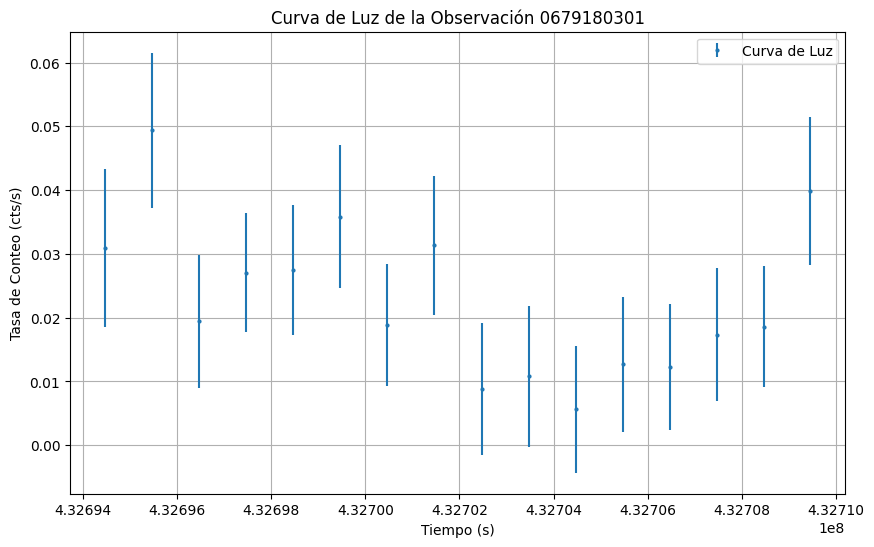

In [115]:
l_file = lfiles_candidate[1]
# Seleccionar el primer archivo de curva de luz encontrado
lc_ftz_file = os.path.join(path, l_file)
lc_fits_file = lc_ftz_file.replace('.FTZ', '.FITS')

# Descomprimir el archivo .FTZ a .FITS
with gzip.open(lc_ftz_file, 'rb') as f_in:
    with open(lc_fits_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Abrir el archivo FITS de la curva de luz
hdul = fits.open(lc_fits_file)
data = hdul[1].data

# Extraer el tiempo y la tasa de conteo
time = data['TIME']
rate = data['RATE']
rate_err = data['ERROR']

# Graficar la curva de luz
plt.figure(figsize=(10, 6))
# plt.scatter(time, rate,  label='Curva de Luz')
plt.errorbar(time, rate, yerr=rate_err, fmt='o', markersize=2, label='Curva de Luz')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Conteo (cts/s)')
plt.title(f'Curva de Luz de la Observación {obs_id}')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_11923/3400314940.py:24: RuntimeWarning: invalid value encountered in power
  return A * (f / fb) ** (-alpha1) * (1 + (f / fb) ** 4) ** ((alpha1 - alpha2) / 4)
/tmp/ipykernel_11923/3400314940.py:24: RuntimeWarning: divide by zero encountered in power
  return A * (f / fb) ** (-alpha1) * (1 + (f / fb) ** 4) ** ((alpha1 - alpha2) / 4)


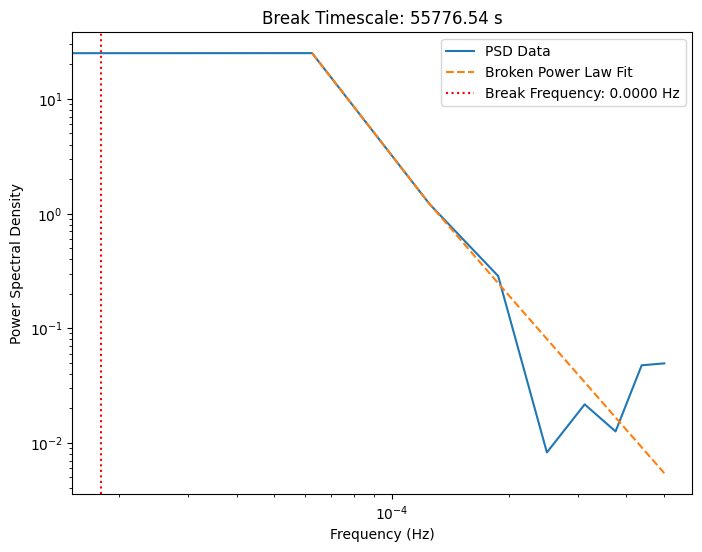

Break Timescale (T_B): 55776.54 s


In [123]:
# Código de ejemplo

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.optimize import curve_fit

l_file = lfiles_candidate[-1]


# Simulación de una curva de luz con ruido (en un caso real, se carga desde los datos XMM-Newton)
np.random.seed(42)
# time = np.linspace(0, 50000, 5000)  # 5000 puntos en 50000 segundos (~14h)
# flux = np.cumsum(np.random.normal(0, 1, size=len(time)))  # Señal aleatoria con tendencia
time = data["TIME"]
rate = data['RATE']
flux = rate.cumsum()

# Calcular la Power Spectral Density (PSD) con la función de Welch
frequencies, psd = welch(flux, fs=1/(time[1] - time[0]), nperseg=256)

# Función de ajuste para el PSD (Power Law con Break)
def broken_power_law(f, A, fb, alpha1, alpha2):
    return A * (f / fb) ** (-alpha1) * (1 + (f / fb) ** 4) ** ((alpha1 - alpha2) / 4)

# Estimación inicial para el ajuste (A, fb, alpha1, alpha2)
p0 = [1e3, 1e-3, 1, 2]

# Ajuste del modelo al PSD
popt, _ = curve_fit(broken_power_law, frequencies[1:], psd[1:], p0=p0, maxfev=100000)

# Extraer el break timescale (T_B = 1 / f_B)
T_B = 1 / popt[1]

# Graficar el PSD y el ajuste
plt.figure(figsize=(8,6))
plt.loglog(frequencies, psd, label="PSD Data")
plt.loglog(frequencies, broken_power_law(frequencies, *popt), linestyle="--", label="Broken Power Law Fit")
plt.axvline(popt[1], color='r', linestyle=':', label=f'Break Frequency: {popt[1]:.4f} Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.title(f"Break Timescale: {T_B:.2f} s")
plt.show()

print(f"Break Timescale (T_B): {T_B:.2f} s")